# Time Series Prediction using LSTM

In [9]:
%matplotlib inline

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras_models import lstm

from providens.frame_wrapper import DataFrameWrapper
""" Wrapper for two-dimensional size data (pandas.DataFrame) to be used by
any machine learning model for predicting either value from the last column
or value defined by name. To produce train and test sets, the data can be
structured in two ways:
1) tensor with dimensions (n x nb_steps x nb_features), where 'n' is a total
number of samples to feed a model with, 'nb_steps' is a number of steps to
the past, defining number of previous information used for predicting next
value, and 'nb_features' is a number representing associated information
for each sample;
2) matrix n x nb_features, where 'n' is a number of sample to feed a model
with, and 'nb_features' is a number representing all input information as
1d-array associated with a value to predict

Parameters
----------
df : pandas.DataFrame
    Data to wrap
target_name : string, default None
    Column to use as target, otherwise the last column
scale : boolean, default True
    Scale features data

Examples
--------
>>> df = pd.DataFrame(np.random.randn(10, 3),
...                   columns=['feature_1', 'feature_2', 'Price'])
>>> target = 'Price'
>>> df = DataFrameWrapper(df, target_name=target)
"""

def forecast(df, model, target_name=None, mdata=None, test_size=0.1, history_size=6, use_past=True, is_lstm=True):
    survey_data = DataFrameWrapper(df, target_name)
    if mdata is not None:
        survey_data.append_macro_data(mdata)
    X_train, y_train, X_test, y_test = survey_data.train_test_split(test_size=test_size, history_size=history_size,
                                         use_past_features=use_past, for_lstm=is_lstm)
    """train_test_split splits into random train and test subsets

    Parameters
    ----------
    test_size : float, int, or None (default is None)
    history_size : int
        steps to the past
    use_past_features : boolean, default True
        use history_size steps back features or just past values of target
    for_lstm : boolean, default True
        if True, then data created in 3d from (n x nb_steps x nb_features),
        otherwise it is flatten to (n x nb_steps * nb_features)
    shuffle : boolean, default True          
        shuffle train data

    Returns
    -------
    splitting : list, length = 4
        List containing train-test split of inputs:
        X shape is (n x nb_steps x nb_features) or (n x nb_steps * nb_features)
        y shape is (n, 1) or (n,)
        *described above (DataFrameWrapper)
    """    
    print 'Prepared train and test data shape: {}, {}'.format(X_train.shape, X_test.shape)

    model = model.fit(X_train, y_train)
    
    # Run trained network over the train and test data:
    y_train_predicted = model.predict(X_train).flatten()
    y_test_predicted = model.predict(X_test).flatten()
    pdf = survey_data.wrap_prediction(y_train_predicted, y_test_predicted)
    for c in pdf:
        pdf[c] = survey_data.inverse_transform_target(pdf[c])
    pdf.tail()
    
    pidx = survey_data.get_pindex()
    ax = pdf.plot(figsize=(12, 4), style=['b-', 'r:'], linewidth=1)
    train_test_border = pd.to_datetime(pdf.index[pidx])
    ax.set_xticks([train_test_border], minor=True)
    ax.grid('on', which='minor', axis='x', color='r', linestyle='--') 

    # Out of sample prediction, when each old data is replaced with newly predicted:
    pdf['Forecast'] = survey_data.forecast_with_model(model, history_size, use_past, is_lstm)
    pdf['Forecast'] = survey_data.inverse_transform_target(pdf['Forecast'])
    pdf.iloc[pidx:,:].plot(style=['b-', 'r:', 'g--'], linewidth=1)

In [11]:
import statsmodels.api as sm
data = sm.datasets.sunspots.load_pandas().data.drop('YEAR', axis=1)
data.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SUNACTIVITY,309.0,49.752104,40.452595,0.0,16.0,40.0,69.8,190.2


Prepared train and test data shape: (273, 1, 6), (30, 1, 6)
Compiling Model ... 
Model has 691 parameters.
(273, 1, 6) (273,)


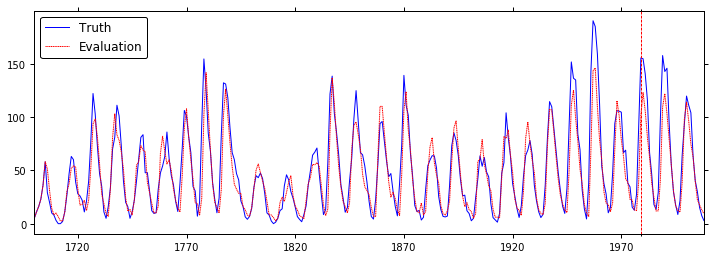

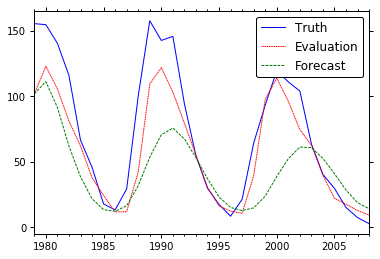

In [12]:
model = lstm(hidden_neurons=10, nb_epoch=30, batch_size=10)
forecast(data, model)

In [13]:
data = pd.read_csv('data/google_2004_2010.csv', index_col='Date', parse_dates=True, na_values=['-'])
data.sort_index(axis=0, ascending=True, inplace=True)# new dates to the end
sp_data = pd.read_csv('data/sp500_2004_2010.csv', index_col='Date', parse_dates=True, na_values=['-'])
sp_data.sort_index(axis=0, ascending=True, inplace=True)# new dates to the end
sp_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SP500_Close,1614.0,1.210457e+03,1.834751e+02,6.765300e+02,1.109865e+03,1.209410e+03,1.336530e+03,1.565150e+03
SP500_Volume,1614.0,3.383082e+09,1.815775e+09,5.045800e+08,1.900668e+09,2.786040e+09,4.613232e+09,1.145623e+10


Prepared train and test data shape: (1220, 7, 4), (135, 7, 4)
Compiling Model ... 
Model has 611 parameters.
(1220, 7, 4) (1220,)


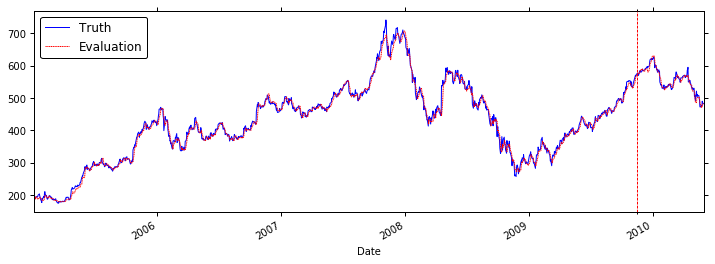

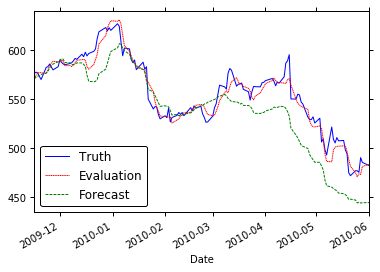

In [14]:
model = lstm(hidden_neurons=10, nb_epoch=100, batch_size=100)
forecast(data, model, 'GOOGLE_Close', mdata=sp_data)

In [15]:
from data import DataLoader
from utils import macro_data
realis_data = DataLoader().get_data('Realis').load(["Bishnan"])
data = realis_data.mean_monthly_price()
data.sort_index(axis=0, ascending=True, inplace=True)# new dates to the end
macro_data = macro_data.load()
macro_data.sort_index(axis=0, ascending=True, inplace=True)# new dates to the end
macro_data = macro_data.asfreq('D', method='ffill')
macro_data.describe()

,Contracts Awarded - Total Public & Private Sector (Million Dollars) _01,Building Work (Million Dollars) _02,Residential (Million Dollars) _03,All Types Private Residential Properties Available _2,Detached Houses Available _2,Semi-Detached Houses Available _2,Terrace Houses Available _2,Apartments Available _2,Condominium Units Available _2,All Types Private Residential Properties Vacant _2,...,Loans,Household Net Worth _11,Public Housing _11,Private Housing _11,Mortgage Loans _11,Personal Loans _11,Consumer Price Index All Items _12,Consumer Price Index Food _12,Consumer Price Index Housing & Utilities _12,Consumer Price Index Transport _12
count,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,...,9863.000000,9.863000e+03,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000
mean,20862.285593,16598.439339,7324.850705,198589.728683,8859.295549,18200.375646,32367.482105,53973.899828,85188.675555,13774.985197,...,67992.423938,7.977986e+05,239770.370841,236751.325935,114324.334878,43662.856028,79.893187,79.828500,72.381681,78.519055
std,9019.246779,7181.670349,3596.248519,76376.086836,2864.820558,5155.708632,9330.436412,18461.331021,44095.674409,5200.903383,...,56812.948363,3.795115e+05,99154.772965,101100.272380,58055.480192,17458.885902,11.089828,12.039972,14.404492,11.287433
min,7873.500000,6597.200000,2685.000000,68788.000000,2702.000000,7200.000000,12643.000000,20900.000000,25343.000000,4776.000000,...,5863.800000,4.257865e+05,121615.100000,114169.800000,39775.900000,23924.500000,62.218000,63.120000,53.643000,56.919000
25%,12832.200000,10915.400000,4638.100000,149114.000000,9889.000000,18779.000000,32611.000000,48103.000000,39370.000000,9262.000000,...,20402.300000,4.874389e+05,176511.900000,166146.400000,58316.900000,30392.700000,72.748000,71.781000,61.555000,72.781000
50%,20162.800000,14135.400000,6733.900000,209823.000000,10053.000000,20592.000000,36501.000000,57831.000000,85005.000000,14623.000000,...,49412.700000,6.008565e+05,205093.500000,176405.400000,113973.100000,40779.000000,75.784000,74.866000,66.043000,74.835000
75%,27034.000000,21560.200000,11073.600000,254334.000000,10294.000000,21174.000000,38142.000000,65724.000000,118958.000000,16877.000000,...,101133.100000,1.113507e+06,327281.200000,311656.900000,148299.500000,50567.500000,87.002000,89.928500,82.899000,81.587000
max,38757.100000,28862.700000,15963.200000,311635.000000,10688.000000,21791.000000,39176.000000,81302.000000,158678.000000,24062.000000,...,179135.100000,1.492889e+06,421670.300000,428489.400000,218775.800000,77777.400000,100.251000,103.692000,101.136000,107.058000


Prepared train and test data shape: (197, 7, 41), (35, 7, 41)
Compiling Model ... 
Model has 2091 parameters.
(197, 7, 41) (197,)


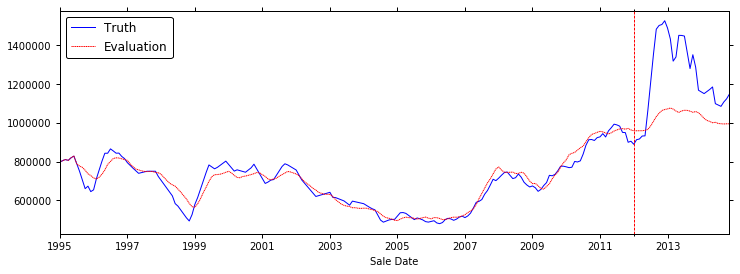

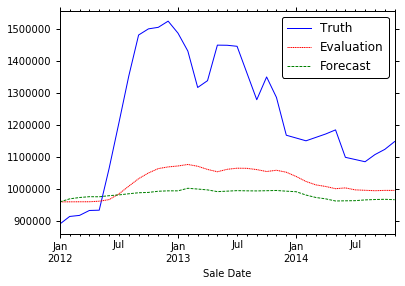

In [16]:
model = lstm(hidden_neurons=10, nb_epoch=10, batch_size=5)
forecast(data, model, 'Transacted Price ($)', mdata=macro_data, test_size=0.15)